In [65]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = pd.read_csv('./diabetes.csv')

inputs = data.drop('Outcome', axis = 1)
inputs = np.array(inputs)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
sc = MinMaxScaler()
inputs = sc.fit_transform(inputs)
outputs = data['Outcome'].as_matrix()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.10, random_state=42)

plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

/home/rishi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()


In [66]:
import numpy as np

class Neuron:
    def __init__(self):
        self.type = 'relu'
        self.fp = 0
        self.z = 0
        self.W = []
        self.b = 0
        self.ac_1 = []
        self.dz=0
    
    def _weighted_sum(self):
        summ = 0
        for i in range(len(self.ac_1)):
            summ+=self.ac_1[i]*self.W[i]
        return summ + self.b
    
    def _activation_fn(self):
        if(self.type=='relu'):
            if self.z > 0:
                return self.z
            return 0
        elif(self.type=='sigm'):
            return 1/(1+np.exp(-self.z))
        else:
            raise Exception('Invalid Activation Function')
                    
    def forward_propogate(self,inp,weights,bias,choice='relu'):
        assert(len(inp)==len(weights))
        self.type=choice
        self.ac_1 = inp
        self.W = weights
        self.b = bias
        self.z = self._weighted_sum()
        self.fp = self._activation_fn()
        return self.fp

    def _back_activation_fn(self):
        if(self.type=='relu'):
            if(self.z<0):
                return 0
            else:
                return self.dac
        elif(self.type=='sigm'):
            return self.dac*self.fp*(1-self.fp)
        else:
            raise Exception("Invalid activation function")

    def back_propogate(self,dac):
        self.dac = dac
        self.dz = self._back_activation_fn()
        m = len(self.ac_1)
        dw = np.array(self.ac_1)*self.dz
        db = self.dz
        dac_1 = np.array(self.W)*self.dz
        return dw,db,dac_1

class Layer:
    def __init__(self, n_neurons):
        self.neurons = []
        self.n_neurons = n_neurons
        for i in range(self.n_neurons):
            self.neurons.append(Neuron())
    
    def forward_propogate(self, inputs, weights,bias,choice='relu'):
        output = []
        for i in range(self.n_neurons):
            output.append(self.neurons[i].forward_propogate(inputs,weights[i],bias[i],choice))
        return output
    
    def back_propogate(self,dacs):
        dacs=np.array(dacs.mean(axis=0))
        dws = []
        dbs = []
        dac_1s = []
        for i in range(dacs.shape[0]):
            temp1,temp2,temp3 = self.neurons[i].back_propogate(dacs[i])
            dws.append(temp1)
            dbs.append(temp2)
            dac_1s.append(temp3)
        return np.array(dws),np.array(dbs),np.array(dac_1s)
    

class Neural_Net:
    def __init__(self, layers):
        self.n_layers=len(layers)
        self.inputs=None
        self.outputs=None
        self.Layers=[]
        self.Weights=[]
        self.WGrads = []
        self.Bias=[]
        self.BGrads = []
        self.layers=layers
        self.learning_rate = 0
        self.n_inps = 0
        self.inputs_val = None
        self.outputs_val = None
        
    def _showWandB(self):
        print('Weights:',self.Weights)
        print('Bias:',self.Bias)
        
    def _showGWandBG(self):
        print('WGrads:',self.WGrads)
        print('BGrads:',self.BGrads)
        
    def _initialize(self):
        for i in range(self.n_layers):
            self.Layers.append(Layer(self.layers[i]))
            if i==0:
                self.Weights.append(np.random.randn(self.layers[i],len(self.inputs[0])))#####
                self.Bias.append(np.random.randn(self.layers[0]))
            else:
                self.Weights.append(np.random.randn(self.layers[i],self.layers[i-1]))
                self.Bias.append(np.random.randn(self.layers[i]))
        self.Layers.append(Layer(1))
        self.Weights.append(np.random.randn(1,self.layers[self.n_layers-1]))
        self.Bias.append(np.random.randn(1))
                
    def _forward_propogate(self,temp):
        for i in range(len(self.Layers)):
            if i==0:
                temp = self.Layers[i].forward_propogate(temp,self.Weights[i],self.Bias[i],'relu')
            elif i==self.n_layers:
                temp = self.Layers[i].forward_propogate(temp,self.Weights[i],self.Bias[i],choice='sigm')
            else:
                temp = self.Layers[i].forward_propogate(temp,self.Weights[i],self.Bias[i],'relu')
        return temp
    
    def _compute_cost(self,pred,act,cost_type = 'crs_ent'):
        temp_out = np.array(pred)
        act=np.array(act)
        act = np.expand_dims(act,axis=0)
        m = act.shape[0]
        if(cost_type == 'mse'):
            cost = (1/(2*m))*(np.array(temp_out)-np.array(act))**2
            cost_der = np.array(temp_out)-np.array(act)
        elif(cost_type == 'crs_ent'):
#             print("m is ", m)
            if(temp_out==1):
                temp_out-=0.00001
            elif(temp_out==0):
                temp_out+=0.00001
            cost = (-1 / m) * (np.multiply(act, np.log(temp_out)) + np.multiply(1 - act, np.log(1 - temp_out)))
            cost_der =  (-1/m)* (np.divide(act, temp_out) - np.divide(1 - act, 1 - temp_out))
        else:
            raise Exception('Invalid cost function given.')
        return cost,cost_der
    
    def _back_propogate(self,cost_der):
        temp3 = np.array(cost_der)
        temp3 = np.expand_dims(temp3,axis=1)
        Wg = []
        Bg = []
        for i in reversed(range(len(self.Layers))):
            temp1, temp2, temp3 = self.Layers[i].back_propogate(temp3)
            Wg.insert(0,temp1)
            Bg.insert(0,temp2)
        return Wg,Bg
                
    def _update_weights(self):
        for i in range(len(self.Layers)):
            self.Weights[i] = self.Weights[i] - self.learning_rate * self.WGrads[i]
            self.Bias[i] = self.Bias[i] - self.learning_rate * self.BGrads[i]
     
    def train(self,inps,outs,inp_val,out_val,epochs=50,learning_rate = 0.03,printCost=False,printEvery = 10):
        self.inputs = inps
        self.outputs = outs
        self.inputs_val = inp_val
        self.outputs_val = out_val
        self.learning_rate = learning_rate
        self._initialize()
        cost_av = 0
        cost_der_av = 0
        self.n_inps = self.inputs.shape[0]
        costs = []
        trn_acc = []
        tst_acc = []
        WGtemp = []
        BGtemp = []
        for i in range(epochs):
            if(printCost and i%printEvery==0):
                print("Epoch %d/%d,"%(i+1,epochs),end=" ")
#             self._showWandB()
            for j in range(len(self.inputs)):
                pred = self._forward_propogate(self.inputs[j])
#                 print(pred,end=" ")
                cost,cost_der = self._compute_cost(pred,self.outputs[j])
                WGtemp,BGtemp=self._back_propogate(cost_der)
                cost_av+=cost
                cost_der_av+=cost_der
                if(j==0):
                    self.WGrads = WGtemp
                    self.BGrads = BGtemp
                else:
                    for k in range(len(self.Layers)):
                        self.WGrads[k]=self.WGrads[k]+WGtemp[k]
                        self.BGrads[k]=self.BGrads[k]+BGtemp[k]
            for j in range(len(self.Layers)):
                self.WGrads[j]=self.WGrads[j]/self.n_inps
                self.BGrads[j]=self.BGrads[j]/self.n_inps
            cost_av/=self.n_inps
            cost_der_av/=self.n_inps
            if(printCost and i%printEvery==0):
                print("Cost = %f,"%(cost_av),end=" ")
                _,acc1 = self.predict_classes(self.inputs,self.outputs)
                _,acc2 = self.predict_classes(self.inputs_val, self.outputs_val)
                print("Training Accuracy = %f, Validation Accuracy = %f"%(acc1,acc2))
                trn_acc.append(acc1)
                tst_acc.append(acc2)
                costs.append(cost_av[0])
#             self._showGWandBG()
            self._update_weights()
        print("Epoch %d/%d,"%(epochs,epochs),end=" ")
        print("Cost = %f,"%(cost_av),end=" ")
        _,acc1 = self.predict_classes(self.inputs,self.outputs)
        _,acc2 = self.predict_classes(self.inputs_val, self.outputs_val)
        print("Training Accuracy = %f, Validation Accuracy = %f"%(acc1,acc2))
        
        plt.subplot(2, 1, 1)
        plt.plot(np.squeeze(costs))
        plt.ylabel('Cost')
        plt.xlabel('Epochs')
        plt.title("Learning rate =" + str(self.learning_rate))
        
        plt.subplot(2, 1, 2)
        plt.plot(trn_acc)
        plt.plot(tst_acc)
        plt.ylabel('Accuracy')
        plt.xlabel('Epochs')
        plt.legend(['Train Acc, Test Acc'])
        plt.title("Training and Test Acuuracies")
        
        plt.show()
        
        return costs
#         self._showWandB()
#         self._showGWandBG()

    def predict(self,p):
        preds = []
        for temp in p:
            for i in range(len(self.Layers)):
                if i==0:
                    temp = self.Layers[i].forward_propogate(temp,self.Weights[i],self.Bias[i],'relu')
                elif i==self.n_layers:
                    temp = self.Layers[i].forward_propogate(temp,self.Weights[i],self.Bias[i],choice='sigm')
                else:
                    temp = self.Layers[i].forward_propogate(temp,self.Weights[i],self.Bias[i],'relu')
            preds.append(temp)
        return preds
    
    def predict_classes(self,p,q):
        preds = np.array(self.predict(p))
        preds[preds>0.5]=1
        preds[preds<=0.5]=0
        preds = np.squeeze(preds)
        acc = np.sum((preds == q)/p.shape[0])
        return preds,acc

Epoch 1/400, Cost = 2.005995, Training Accuracy = 0.348770, Validation Accuracy = 0.350649
Epoch 21/400, Cost = 0.639317, Training Accuracy = 0.723589, Validation Accuracy = 0.727273
Epoch 41/400, Cost = 0.597915, Training Accuracy = 0.729378, Validation Accuracy = 0.727273
Epoch 61/400, Cost = 0.576058, Training Accuracy = 0.733719, Validation Accuracy = 0.727273
Epoch 81/400, Cost = 0.562420, Training Accuracy = 0.735166, Validation Accuracy = 0.727273
Epoch 101/400, Cost = 0.553282, Training Accuracy = 0.739508, Validation Accuracy = 0.727273
Epoch 121/400, Cost = 0.546453, Training Accuracy = 0.745297, Validation Accuracy = 0.727273
Epoch 141/400, Cost = 0.540941, Training Accuracy = 0.746744, Validation Accuracy = 0.727273
Epoch 161/400, Cost = 0.535964, Training Accuracy = 0.743849, Validation Accuracy = 0.714286
Epoch 181/400, Cost = 0.531146, Training Accuracy = 0.749638, Validation Accuracy = 0.727273
Epoch 201/400, Cost = 0.526733, Training Accuracy = 0.753980, Validation Acc

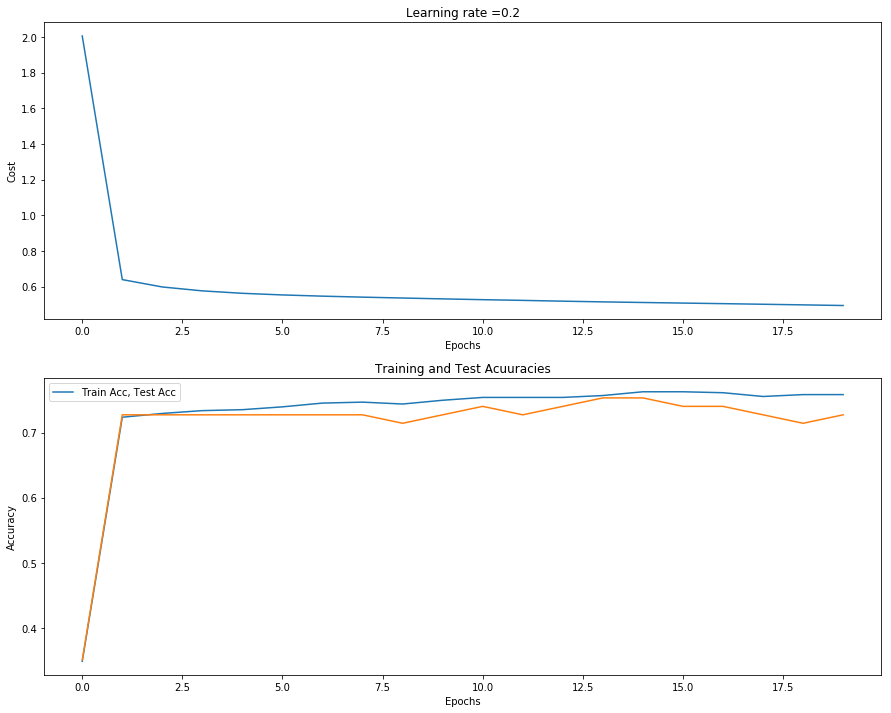

In [67]:
np.random.seed(10)
net = Neural_Net([10,5])
costs = net.train(X_train,y_train,X_test,y_test,epochs=400,learning_rate=0.2,printCost=True,printEvery=20)

In [41]:
costs

[2.005994737001663,
 0.6829267257731613,
 0.6393170190150906,
 0.6146548444056156,
 0.5979152130941,
 0.5856059104919977,
 0.5760575081239716,
 0.5684918300637605,
 0.5624199553845057,
 0.5574503238483368]

In [42]:
preds = net.predict(X_train)
preds

[[0.23573763008256843],
 [0.24545595582963575],
 [0.3869429681931247],
 [0.5130711370734635],
 [0.23573763008256843],
 [0.23573763008256843],
 [0.4351333446161539],
 [0.2385921582593225],
 [0.5044670678224769],
 [0.732433286758077],
 [0.32592425192672336],
 [0.27619259452347095],
 [0.23573763008256843],
 [0.23573763008256843],
 [0.28562692230304065],
 [0.23573763008256843],
 [0.23573763008256843],
 [0.291809044398131],
 [0.46378311783545734],
 [0.3000791447940968],
 [0.23573763008256843],
 [0.5833688669925211],
 [0.23880643977562388],
 [0.30295194732787345],
 [0.23573763008256843],
 [0.793371662393015],
 [0.42634224700531437],
 [0.5713036678912731],
 [0.34504422263155166],
 [0.4044773678045144],
 [0.6774237046383145],
 [0.40555738638046024],
 [0.5369004088361515],
 [0.258026307070056],
 [0.5578865847117986],
 [0.23573763008256843],
 [0.7685393896115941],
 [0.26303543492380305],
 [0.30804757950798056],
 [0.5631497335175144],
 [0.28758276850408904],
 [0.23573763008256843],
 [0.3284465964

In [43]:
classes = net.predict_classes(X_train,y_train)

Accuracy: 0.7395079594790157


In [46]:
classes = net.predict_classes(X_test,y_test)

Accuracy: 0.7272727272727274


In [ ]:
np.random.seed(1)
net = Neural_Net([3,4])
inputs = np.array([[-4,-2],[2,3],[1,1],[-6,-6],[4,5],[7,-10]])
outputs = np.array([1,0,0,1,1,0])

net.train(inputs,outputs,epochs=30,learning_rate=0.3,printCost = False)
print(net.predict([-4,-2]))
print(net.predict([2,3]))
print(net.predict([1,1]))
print(net.predict([-6,-6]))
print(net.predict([4,5]))
print(net.predict([7,-10]))